# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [5]:
# 분석용 데이터 입력
directory_for_ml = '../data/data_for_ml/'
fname = 'df_skhinix_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title = fname[3:7]

In [6]:
data = df.iloc[:, :-5]

# target = df.iloc[:, -5]
# col_num = int(len(data.columns)/4)
# data = data.iloc[:, :col_num]
# target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else 1 ) # 최고가 시간이 오후인 경우
# # target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else (1 if x == 3 else  2 ))
# plt_title2 = '4classes'

# target = df.iloc[:, -1]
# plt_title2 = 'r_open_high_1'

# target = df.iloc[:, -2]
# plt_title2 = 'close_cr_1'

# target = df.iloc[:, -3]
# plt_title2 = 'r_open_high_5'

target = df.iloc[:, -4]
plt_title2 = 'close_cr_5'

In [8]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

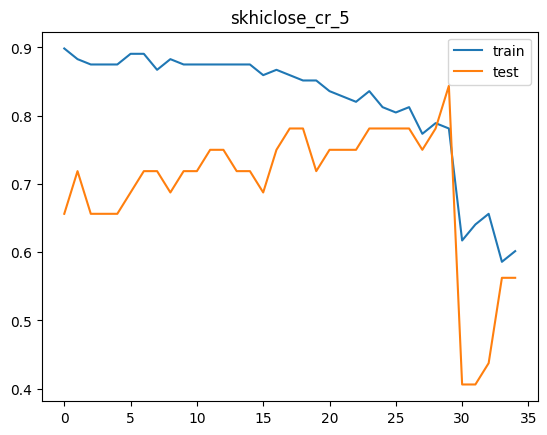

In [9]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

In [10]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['retail', 'dji_cr', 'ixic_cr', 'spx_cr', 'spx_f_cr', 'kospi_cr'], dtype='object') [[-2.52068147 -2.81539835 -2.50404444  2.35962452  2.68111315  1.91990606]]
train_max: 0.8984, test_max: 0.8438


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [12]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [13]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [14]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [15]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [16]:
print("max", max(value))

max 0.7504615384615384


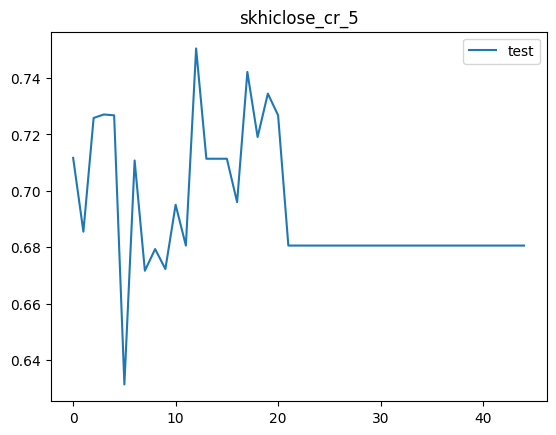

In [17]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [98]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(16, activation='sigmoid', input_shape=(inp_num,)))
#     model.add(Dropout(0.3))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(4, activation='sigmoid'))
#     model.add(Dropout(0.3))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [99]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    model = None
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                112       
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 dense_30 (Dense)            (None, 1)                 5         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [100]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
                                                monitor='val_accuracy', mode='max', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', save_best_only=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', mode='min', restore_best_weights=True)

In [101]:
history = model.fit(train_scaled, train_target, epochs=2000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))

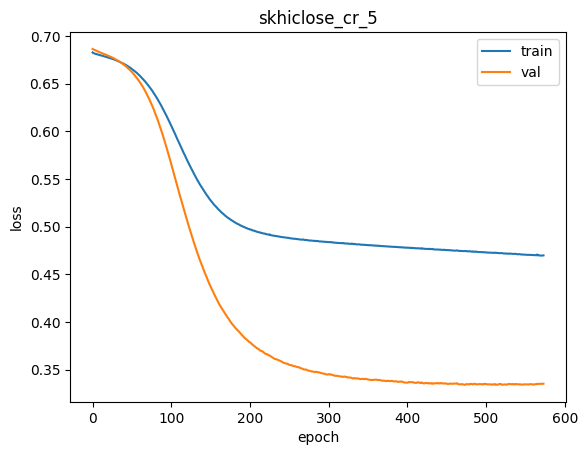

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

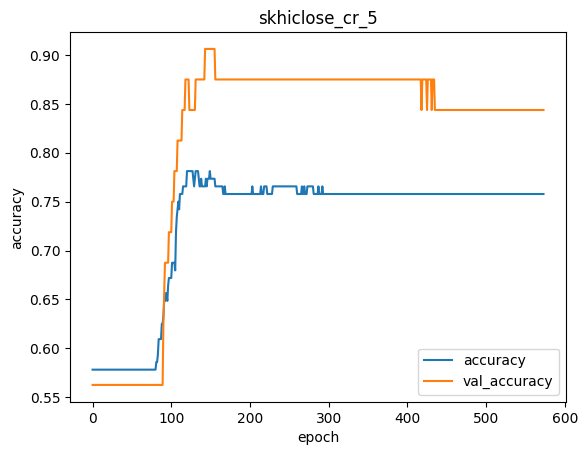

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [108]:
earlystopping_cb.stopped_epoch

573

In [109]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 17ms/step - loss: 0.3338 - accuracy: 0.8438


[0.333823561668396, 0.84375]

In [110]:
model_val = load_model('best_model/best_model_271-0.56-0.91.h5')
model_val.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 84ms/step - loss: 0.5618 - accuracy: 0.9062


[0.5617721080780029, 0.90625]

In [38]:
y_predict = model.predict(np.array(test_scaled))

1/1 [==============================] - 0s 64ms/step


In [39]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [40]:
compare = [ [x, y] for x, y in zip(test_target, y_predict)]
# compare = [ [x, y] for x, y in zip(test_target, y_predict_list)]
compare # 실제값. 예측값

[[1, array([0.5440194], dtype=float32)],
 [1, array([0.7361813], dtype=float32)],
 [0, array([0.09332684], dtype=float32)],
 [0, array([0.12772858], dtype=float32)],
 [0, array([0.10342602], dtype=float32)],
 [1, array([0.79749894], dtype=float32)],
 [1, array([0.8399649], dtype=float32)],
 [1, array([0.66339594], dtype=float32)],
 [0, array([0.17555219], dtype=float32)],
 [0, array([0.15343763], dtype=float32)],
 [1, array([0.81261784], dtype=float32)],
 [0, array([0.09370735], dtype=float32)],
 [0, array([0.11372889], dtype=float32)],
 [1, array([0.76633984], dtype=float32)],
 [0, array([0.72679055], dtype=float32)],
 [0, array([0.5147303], dtype=float32)],
 [1, array([0.5639185], dtype=float32)],
 [0, array([0.09325872], dtype=float32)],
 [1, array([0.28232393], dtype=float32)],
 [1, array([0.8352524], dtype=float32)],
 [0, array([0.14812174], dtype=float32)],
 [1, array([0.7636633], dtype=float32)],
 [0, array([0.12469672], dtype=float32)],
 [0, array([0.10187573], dtype=float32)],

In [70]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 : 양성으로 예측된 것(TP+FP) 중 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

0.8571428571428571

In [71]:
# 재현율 : 전체 양성 샘플(TP+FN) 중에서 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.8571428571428571

In [72]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.8571428571428571

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[16,  2],
       [ 2, 12]], dtype=int64)

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, y_predict_list)

0.873015873015873

1. 정밀도, f1-score, 
2. confusion matrix ((1,1), (2,2), 두개가 큰 비중이면 good, (1,2)은 틀린것을 맞다라고 구분, (2,1)은 맞는 것을 틀린 것이다 라고 결정하는 항목) 따라서
    (2,2) -> (1,2) -> (1,1)로 확인하고. <br>
    (1,2)가 크면 모델 제외 (정밀도(precision = TP / (TP + FP) )가 높아야 함. 낮으면 손해를 보게 됨.), <br>
    재현율(Recall = TP / (TP + FN) ) 은 손해를 끼치지는 않음.
    
<img src="https://raw.githubusercontent.com/fasthill/My-gist/main/data/picture/confusion_matrix.png" width="800"/> <br>

In [ ]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
#     print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''

수수료: 주식거래수수료 0.015%. 유관기관수수료 0.0036%, 증권거래세 0.08, 농어촌 특별세 0.15%
수수료 : (0.015+0.0036 ) * 2 (사고팔때), 증권거래세 : 0.08 + 0.15 (팔때)
전체 지출 금액율: 0.2672%